In [1]:
import time
import numpy as np
from random import randint
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
prefix = 'sagemaker/DEMO2-deepar'
bucket=" " # your s3 bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [19]:
freq = 'H' ## hour
prediction_length = 48
context_length = 72 # context_length is short memory, supposed close to the prediction_length, firt try 96 not good
t0 = '2020-01-01 00:00:00'
data_length = 400
num_ts = 300 # number of time series samples
period = 24  # time series cycles' period

In [5]:
# function to add random slope on the time series
def randomslope():
    slope=np.random.randint(-5,10)
    if slope==0:
        slope=1
    return slope

In [6]:
time_series = []
for k in range(num_ts):
    level = 10 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    slope=randomslope()
    time_ticks_trend = time_ticks*slope*0.0005
    data = source + noise + time_ticks_trend
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))

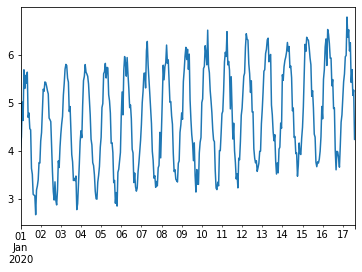

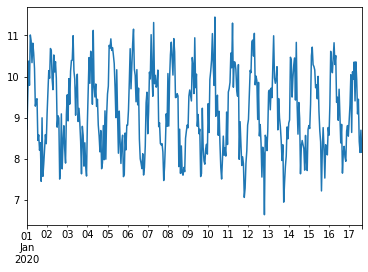

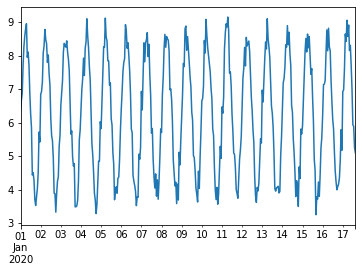

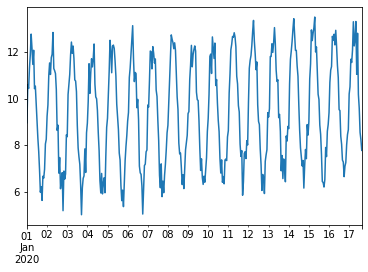

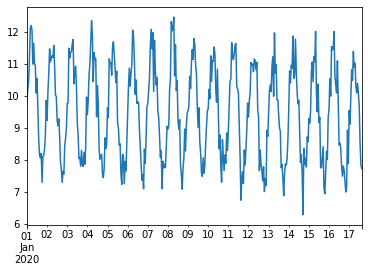

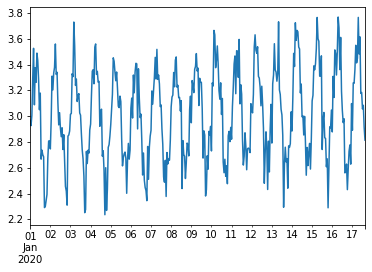

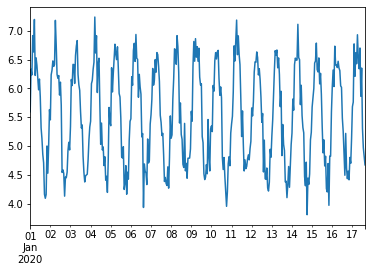

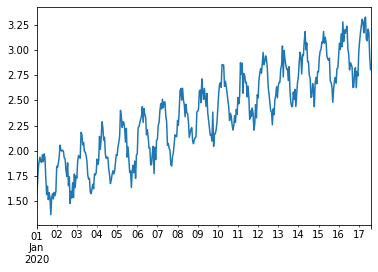

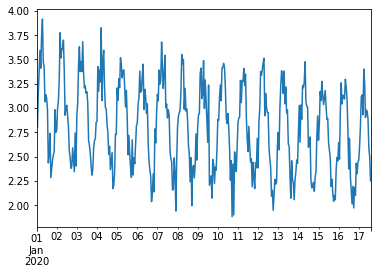

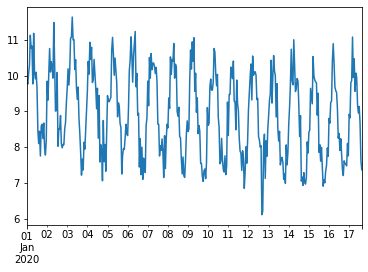

In [7]:
#plot top 10 time series samples
for i in range(10):
    time_series[i].plot()
    plt.show()

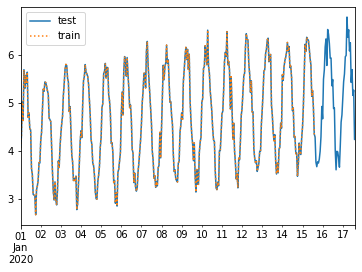

In [8]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])
    

time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

In [20]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))


encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [21]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [22]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-04 17:00:39 Starting - Starting the training job...
2020-09-04 17:00:42 Starting - Launching requested ML instances.........
2020-09-04 17:02:14 Starting - Preparing the instances for training...
2020-09-04 17:03:09 Downloading - Downloading input data......
2020-09-04 17:04:10 Training - Training image download completed. Training in progress..Arguments: train
[09/04/2020 17:04:12 INFO 140437435365184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patienc

In [23]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

-----------------!

In [24]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [25]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [26]:
list_of_df = predictor.predict(time_series_training[:10])
actual_data = time_series[:10]

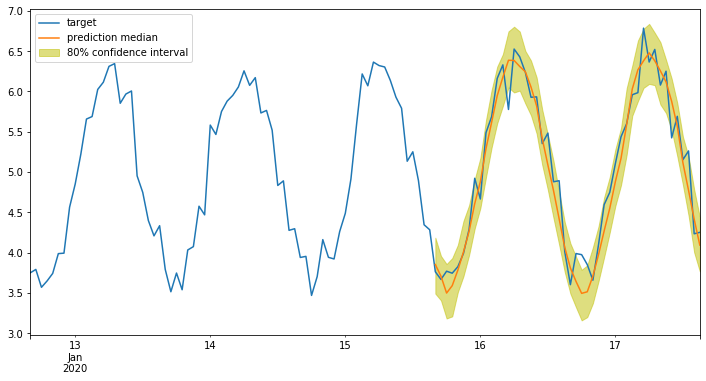

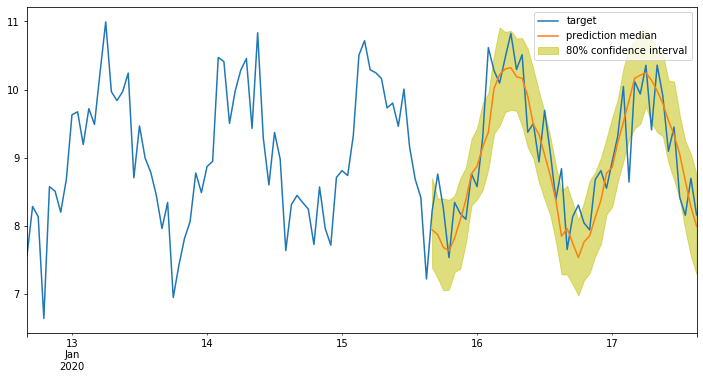

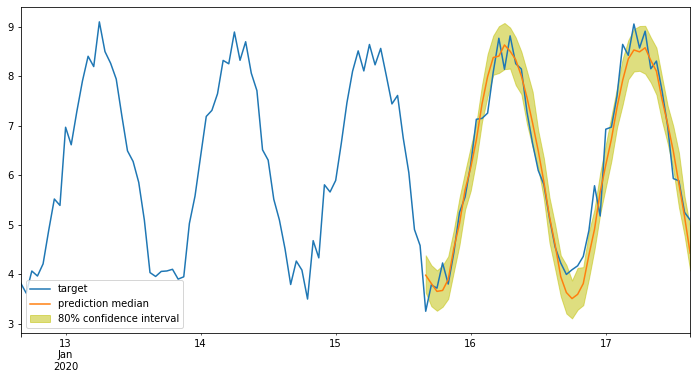

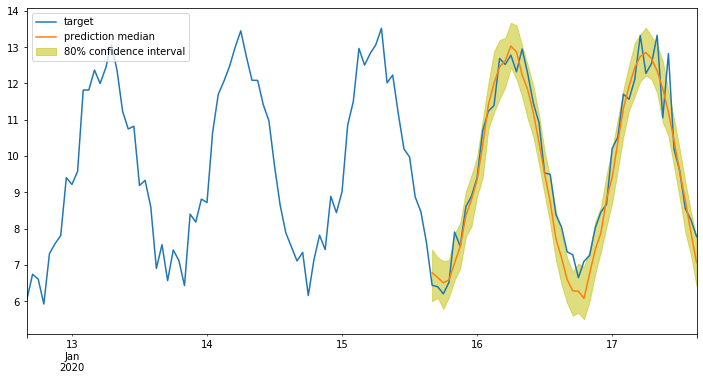

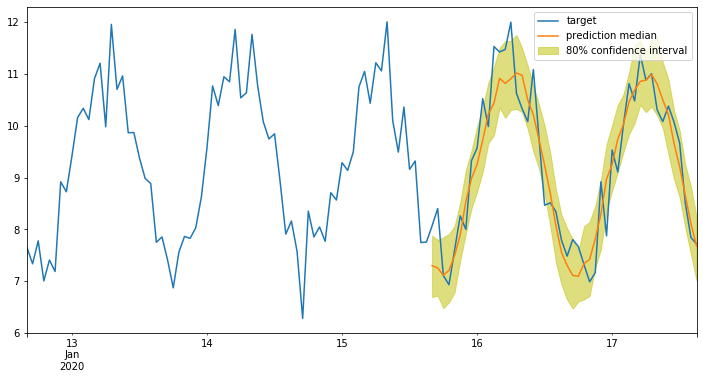

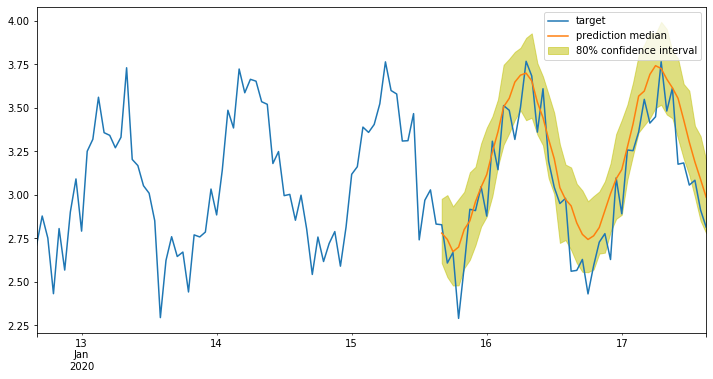

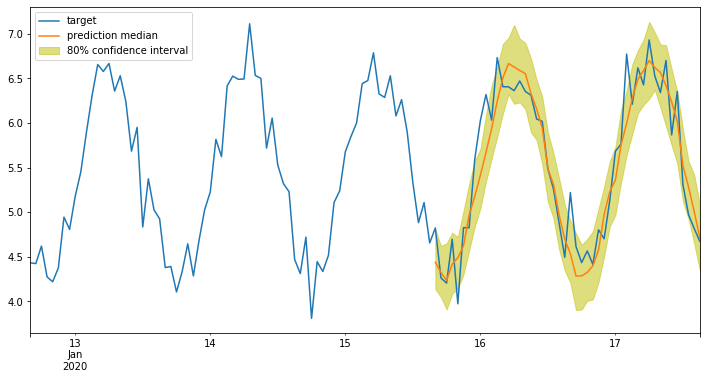

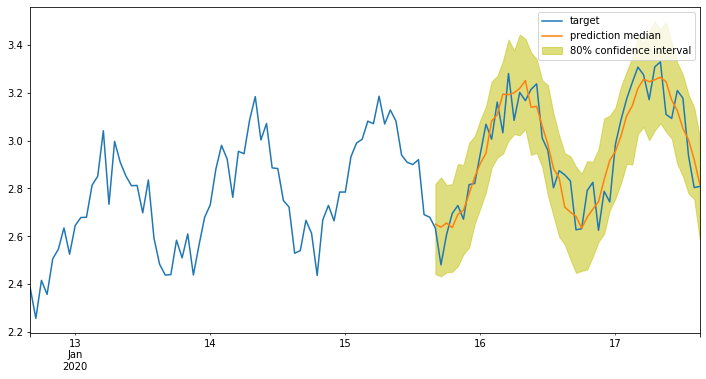

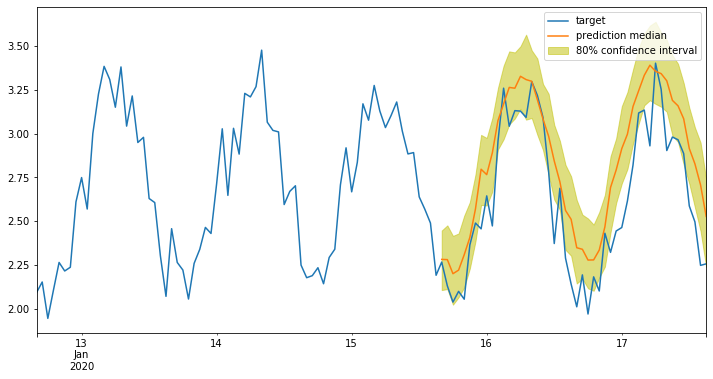

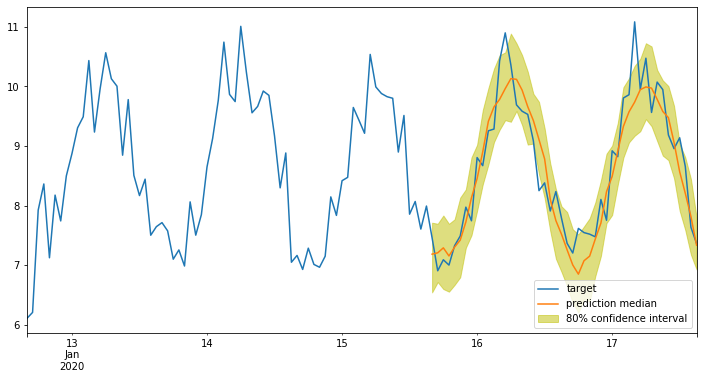

In [28]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

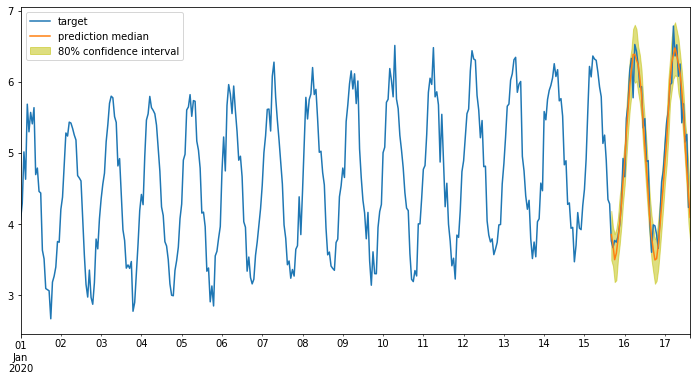

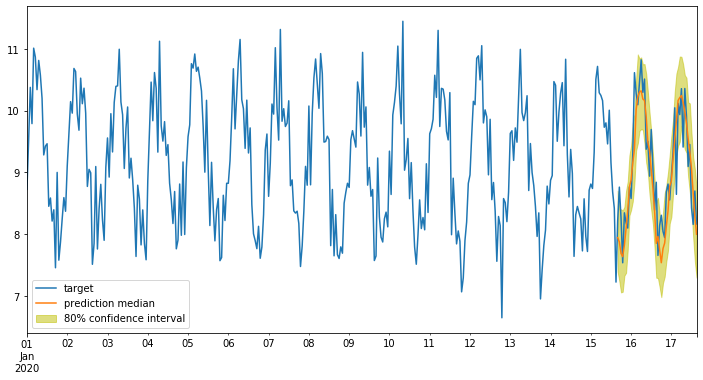

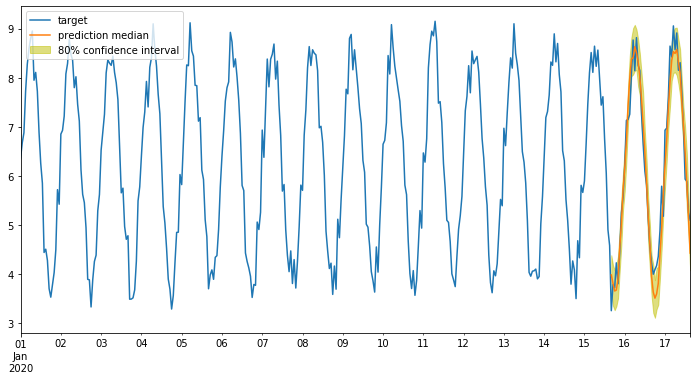

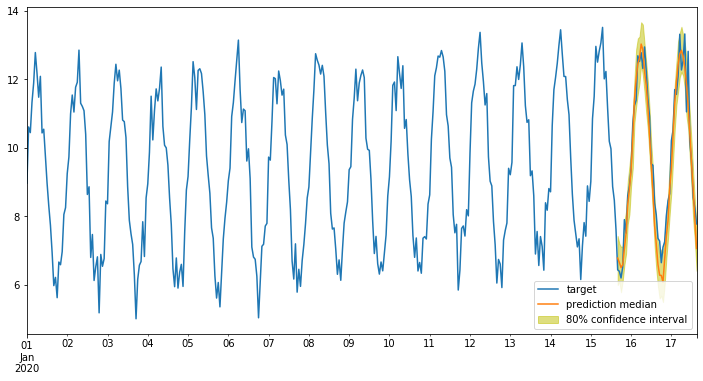

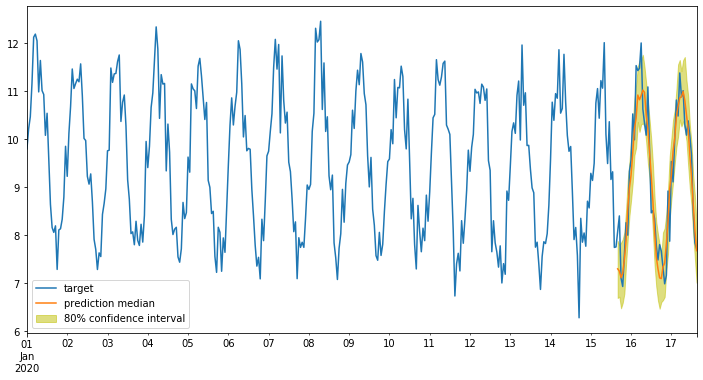

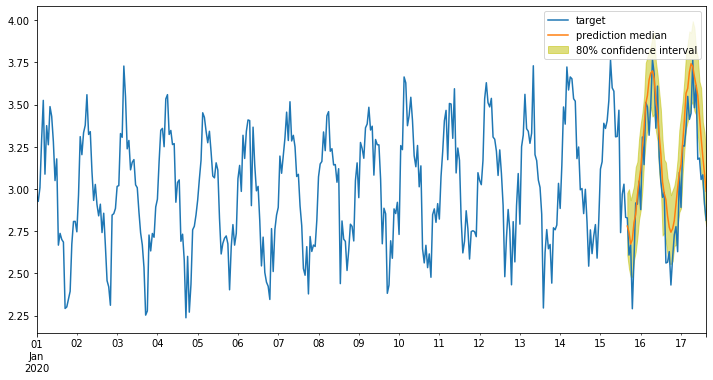

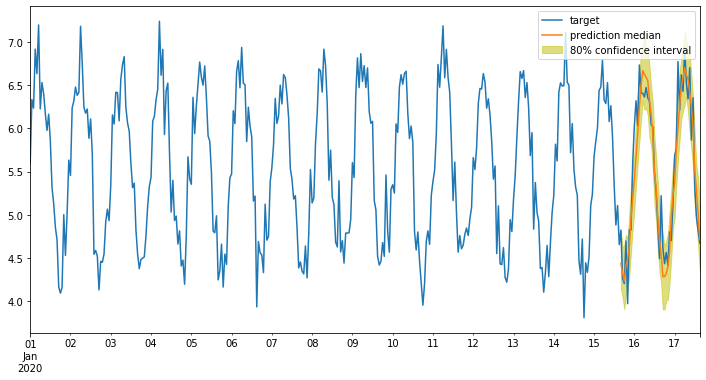

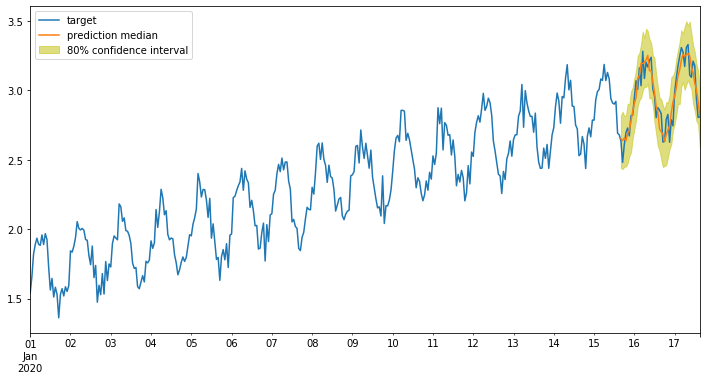

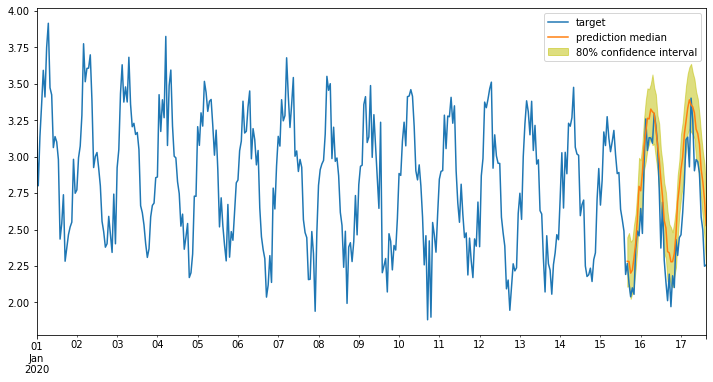

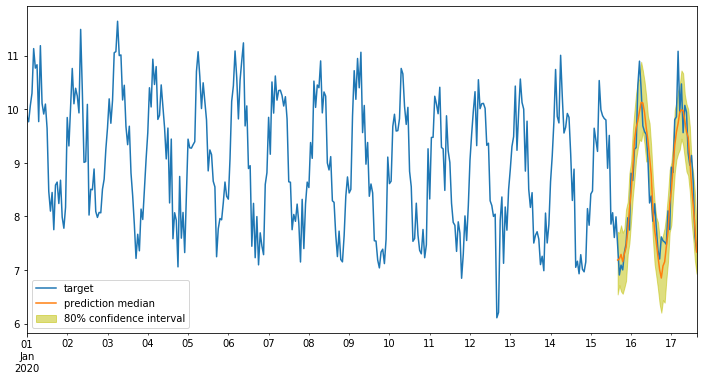

In [27]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [29]:
list_of_df[1]

,0.1,0.9,0.5
2020-01-15 16:00:00,7.391466,8.703153,7.944822
2020-01-15 17:00:00,7.236974,8.403298,7.873549
2020-01-15 18:00:00,7.057002,8.402605,7.687251
2020-01-15 19:00:00,7.067173,8.383713,7.635682
2020-01-15 20:00:00,7.327696,8.441484,7.824568
2020-01-15 21:00:00,7.374436,8.699447,8.088853
2020-01-15 22:00:00,7.749760,8.854593,8.379593
2020-01-15 23:00:00,8.303830,9.276625,8.765773
2020-01-16 00:00:00,8.391473,9.434450,8.877377
2020-01-16 01:00:00,8.529834,9.802459,9.159406
